In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df_train = pd.read_csv("treino+gmm10clusters.csv")
df_train = df_train.drop(columns=["Unnamed: 0"])

In [3]:
df_teste = pd.read_csv("teste+gmm10clusters.csv")
df_teste = df_teste.drop(columns=["Unnamed: 0"])

# Initialize

In [4]:
var_cat = ['BOROUGH','NEIGHBORHOOD','BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','BLOCK','LOT' ,'BUILDING CLASS AT PRESENT',
           'APARTMENT NUMBER', 'ZIP CODE','TAX CLASS AT TIME OF SALE','BUILDING CLASS AT TIME OF SALE']

var_num = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET','YEAR BUILT',
           'sale_month','sale_week','sale_year', 'latitude','longitude',"SALE PRICE"]

usable_num = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET','YEAR BUILT', 'sale_week','sale_year', 'latitude','longitude', "SALE PRICE"]

In [5]:
dataset_train = df_train[var_num]
dataset_test = df_teste[var_num]

In [6]:
dataset_train

RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  \
0                      2                 0            2              2185   
1                      3                 0            3              3000   
2                      1                 0            1              2280   
3                      2                 0            2              2903   
4                      1                 0            1              2755   
...                  ...               ...          ...               ...   
22591                  1                 0            1              2000   
22592                  2                 0            2              1750   
22593                  1                 0            1              1063   
22594                  2                 0            2              1938   
22595                  1                 0            1              3272   

       GROSS SQUARE FEET  YEAR BUILT  sale_month  sale_week  sale_year  \
0                   2160        1930           9         39       2016   
1                   2410        1915           9         35       2016   
2                   1056        1975           2          7       2017   
3                   3520        1910           3         13       2017   
4                   1140        1945           2          6       2017   
...                  ...         ...         ...        ...        ...   
22591               1234        1920           6         23       2017   
22592               1050        1935           9         39       2016   
22593               5070        1920           8         35       2017   
22594               1292        1920          10         40       2016   
22595               1914        1980          11         45       2016   

        latitude  longitude  SALE PRICE  
0      40.900041 -73.847029    440000.0  
1      40.614884 -73.989695   1425000.0  
2      40.589995 -74.155753    605000.0  
3      40.853301 -73.898841    599000.0  
4      40.677263 -73.779484    475000.0  
...          ...        ...         ...  
22591  40.683191 -73.815887    460000.0  
22592  40.618086 -73.997158    720000.0  
22593  40.791797 -73.975188   5500000.0  
22594  40.768942 -73.832058    558000.0  
22595  40.550612 -74.194659    464000.0  

[22596 rows x 12 columns]

## Outlier Trimming

In [7]:
dataset_train = dataset_train[(dataset_train["SALE PRICE"] < dataset_train["SALE PRICE"].quantile(0.98)) &  (dataset_train["SALE PRICE"] > dataset_train["SALE PRICE"].quantile(0.02))]
dataset_test = dataset_test[(dataset_test["SALE PRICE"] < dataset_test["SALE PRICE"].quantile(0.98)) &  (dataset_test["SALE PRICE"] > dataset_test["SALE PRICE"].quantile(0.02))]

# Split Data

In [8]:
X_train, y_train = dataset_train.iloc[:,:-1], dataset_train.iloc[:, -1]
X_test, y_test = dataset_test.iloc[:,:-1], dataset_test.iloc[:, -1]

## Random Search CV

### Random Forest

In [14]:
steps = [('scaler', MinMaxScaler()), ('RandomForest', RandomForestRegressor(n_jobs = -1))]
pipeline = Pipeline(steps)

In [18]:
param_dist = {'RandomForest__n_estimators': [100,200,500,700, 1000],
              'RandomForest__min_samples_split': [2,4,8,16,32]}

In [19]:
# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs = -1 , cv = 10, random_state= 42, verbose = 10)

In [20]:
random_search.fit(X_train, y_train.ravel())

In [20]:
random_search.score(X_test, y_test)
random_search.best_params_
random_search.best_score_
random_search.cv_results_
random_search.best_params_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('RandomForest',
                                              RandomForestRegressor(n_jobs=-1))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'RandomForest__min_samples_split': [2,
                                                                            4,
                                                                            8,
                                                                            16,
                                                                            32],
                                        'RandomForest__n_estimators': [100, 200,
                                                                       500, 700,
                                                                       1000]},
                   random_state=42, verbose=10)

### MLP

In [12]:
steps = [('scaler', MinMaxScaler()), ('MLP', MLPRegressor())]
pipeline = Pipeline(steps)

In [16]:
param_dist = {'MLP__hidden_layer_sizes': [(100,100,1), (10,100,1), (100,200,1), (10,200,100,1) , (10,20,10,1)],
              'MLP__activation': ["relu", "tanh"], 
              'MLP__solver': ["lbfgs","adam"],
             'MLP__learning_rate_init': [10e-4,10e-3,10e-2,10e-1]}

In [17]:
n_iter_search = 20
mlp_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs = -1 , cv = 10, random_state= 42, verbose = 10)

In [ ]:
mlp_search.fit(X_train, y_train.ravel())

# Modelos

## Split Normal

In [9]:
xscaler = StandardScaler().fit(X_train.iloc[:,:11])
yscaler = StandardScaler().fit(y_train.to_numpy().reshape(-1,1))

X_train.iloc[:,:11] = xscaler.transform(X_train.iloc[:,:11])
X_test.iloc[:,:11] = xscaler.transform(X_test.iloc[:,:11])

y_train = yscaler.transform(y_train.to_numpy().reshape(-1,1))
y_test = yscaler.transform(y_test.to_numpy().reshape(-1,1))

## Random Forest

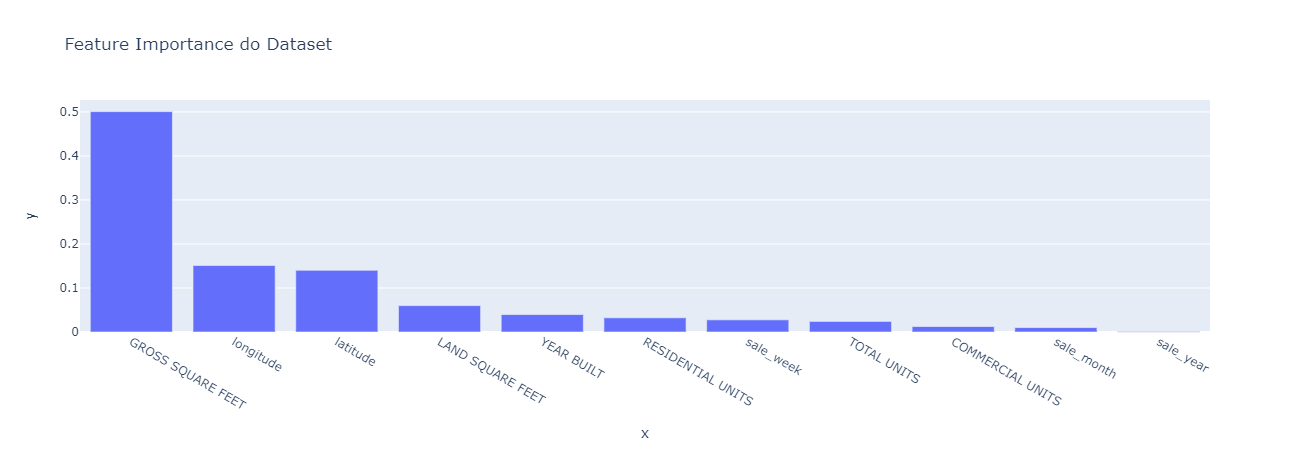

In [26]:
rfr = RandomForestRegressor(n_jobs=-1,min_samples_split = 4, n_estimators = 500)
rfr.fit(X_train, y_train.ravel())
px.bar(x = X_train.columns, y = rfr.feature_importances_, title = "Feature Importance do Dataset").update_xaxes(categoryorder = "total descending")

In [27]:
#R2
rfr.score(X_test,y_test)

0.6931042330122368

In [28]:
#RMSE
np.sqrt(mean_squared_error(y_true = y_test.ravel() , y_pred = rfr.predict(X_test)))

0.47473431320429427

## MLP

In [46]:
mlpr = MLPRegressor(hidden_layer_sizes= (100,100), activation="relu")

In [47]:
mlpr.fit(X_train, y_train.ravel())

c:\users\drocha\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPRegressor(hidden_layer_sizes=(100, 100))

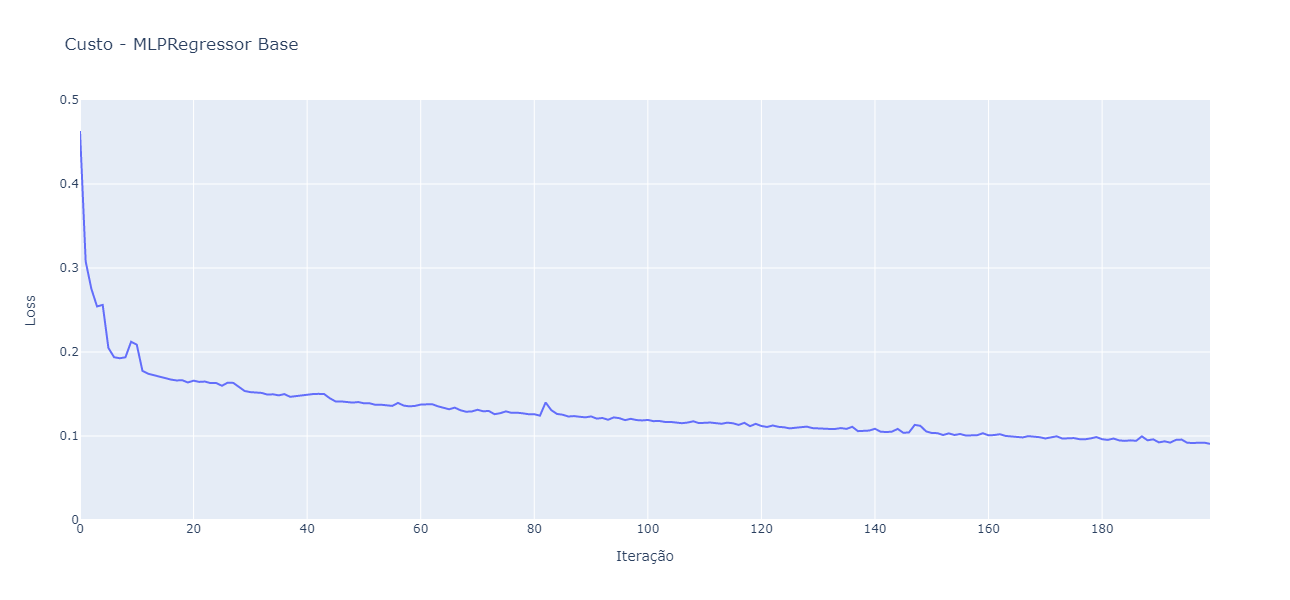

In [65]:
fig = px.line(mlpr.loss_curve_, width = 800, height = 600, title = "Custo - MLPRegressor Base",range_y= [0, 0.5])
fig.update_layout(autosize = False, showlegend = False, xaxis = dict(title = "Iteração"), yaxis = dict(title = "Loss"))

In [49]:
mlpr.score(X_test, y_test) #r2

0.631266287737442

In [50]:
np.sqrt(mean_squared_error(y_true = y_test.ravel() , y_pred = mlpr.predict(X_test)))

0.5203692162289822